# SVM Sklearn 实践
优点:
 - 在高维空间很有效
 - 在决策函数中, 仅仅使用训练样本点中的一部分子集(SV支撑向量点), 非常节省模型内存.
 - 可以使用不同的 kernel.

缺点:
 - 不适合超级大的数据集.因为训练过程中会计算所有训练样本的两两之间的内积.
 - SVMs 不直接提供概率评估, 必须使用计算代价很高的 交叉验证. five-fold cross-validation.

## Classification
`SVC`, `NuSVC` 基本是相同的, 除了他们接受的参数稍微有点不同,因为数学公式不同的原因. 

In [1]:
from sklearn import svm
X = [[0,0],[1,1]]
y = [0, 1]
clf = svm.SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [2]:
clf.predict([[2., 2.]])

array([1])

In [3]:
clf.support_vectors_

array([[ 0.,  0.],
       [ 1.,  1.]])

In [4]:
clf.support_

array([0, 1], dtype=int32)

In [5]:
clf.n_support_

array([1, 1], dtype=int32)

### Multi-class classification
`SVC`, `NuSVC` 都使用的是 `one-against-one` 方法做多分类, 即 k 个类别的话, 内部会训练 k(k-1)/2 个 classifiers, 每一个 classfiler 负责两个类别.

In [6]:
X = [[0], [1], [2], [3]]
Y = [0, 1, 2, 3]
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [7]:
dec = clf.decision_function([[1]])
dec.shape[1] # 4 classes, 4 * 3 / 2 = 6

6

In [8]:
clf.decision_function_shape = 'ovr'
dec = clf.decision_function([[1]])
dec.shape[1]

4

`LinearSVC` 使用的是 `one-vs-rest` multi-classs 策略, k 类别对应 k 个 classfier. 

Automatically created module for IPython interactive environment


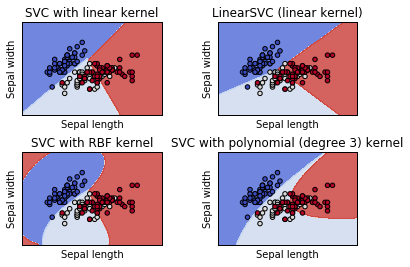

In [9]:
print(__doc__)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

# Case Study
血常规实验报告预测年龄和性别

In [10]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier




data_set = pd.read_csv('./train.csv')
predict_set = pd.read_csv('./predict.csv')

# data = pd.concat([data_set, predict_set], axis=0) #和下面这句等价
data = data_set.append(predict_set)
ids = [id for id in range(len(data.index))]
data['id'] = ids
# 数据合并之后往往索引还是原来两个df的, 为了保持自增, 可以去掉索引.
data.reset_index(drop=True, inplace=True)
data.tail()

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,id,sex,age,WBC,RBC,HGB,HCT,MCV,MCH,MCHC,...,NEU,NEU%,EOS,EOS%,BAS,BAS%,ALY,ALY%,LIC,LIC%
2053,2053,男,77.0,8.7,7.2,0.350,14.2,1.80,20.7,0.58,...,0.5,0.09,1.0,150,0.419,89.0,31.6,356,13.3,488
2054,2054,男,78.0,9.4,7.9,0.136,13.0,1.16,12.4,0.63,...,0.5,0.14,1.5,160,0.459,94.0,32.7,348,9.2,172
2055,2055,男,79.0,14.8,7.6,0.044,16.8,1.60,10.8,0.71,...,0.4,0.98,7.1,85,0.255,90.0,30.2,335,10.8,58
2056,2056,男,81.0,11.0,7.6,0.162,11.0,2.92,26.6,0.64,...,0.6,0.30,2.8,113,0.341,96.0,31.9,332,11.5,215
2057,2057,女,83.0,7.5,9.2,0.164,15.8,1.83,24.4,0.73,...,0.4,0.10,1.4,120,0.352,102.0,34.9,342,10.1,178


### 性别预测

In [11]:
def sex_preprocess(data):
    #不影响原来的数据表格
    df = data.copy()
    # 去掉有缺失维度的数据
    df = df.replace(to_replace='?', value=np.nan)
    df = df.dropna(how='any')
    #pd.get_dummies(data_set)  # one-hot 但是会增加列数, 计算会变慢, 特别是类别很多的时候
    # data_set['sex'] = data_set['sex'].apply(lambda x: 1 if x == '男' else 0)
    df['sex'] = df['sex'].map({'男': 1, '女': 0}).astype(int)
    selected_names = [name for name in df.columns if name != 'id' and name != 'sex' and name != 'age']
    X_data = df[selected_names].as_matrix()
    y_data = df['sex'].as_matrix()
    # SVM 一般要对数据做归一化处理
    #X_data = preprocessing.scale(X_data)
    return X_data, y_data

In [12]:
X_data, y_data = sex_preprocess(data)
data.tail()

,id,sex,age,WBC,RBC,HGB,HCT,MCV,MCH,MCHC,...,NEU,NEU%,EOS,EOS%,BAS,BAS%,ALY,ALY%,LIC,LIC%
2053,2053,男,77.0,8.7,7.2,0.350,14.2,1.80,20.7,0.58,...,0.5,0.09,1.0,150,0.419,89.0,31.6,356,13.3,488
2054,2054,男,78.0,9.4,7.9,0.136,13.0,1.16,12.4,0.63,...,0.5,0.14,1.5,160,0.459,94.0,32.7,348,9.2,172
2055,2055,男,79.0,14.8,7.6,0.044,16.8,1.60,10.8,0.71,...,0.4,0.98,7.1,85,0.255,90.0,30.2,335,10.8,58
2056,2056,男,81.0,11.0,7.6,0.162,11.0,2.92,26.6,0.64,...,0.6,0.30,2.8,113,0.341,96.0,31.9,332,11.5,215
2057,2057,女,83.0,7.5,9.2,0.164,15.8,1.83,24.4,0.73,...,0.4,0.10,1.4,120,0.352,102.0,34.9,342,10.1,178


如果输入数据不同维度的数据范围差异很大, 如果不做归一化处理, 可能有些模型会非常不稳定, 或者收敛很慢甚至无法收敛(如梯度下降的), 例如SVM就对数据归一化敏感 不归一化非常影响准确率. 我猜测可能是 SVM函数中没有 sigmoid 做范围映射.

归一化:
 1. 最值归一化。比如把最大值归一化成1，最小值归一化成-1；或把最大值归一化成1，最小值归一化成0。适用于本来就分布在有限范围内的数据。
 2. 均值方差归一化，一般是把均值归一化成0，方差归一化成1。适用于分布没有明显边界的情况，受outlier影响也较小。

In [13]:
# SVM 一般要对数据做归一化处理
# 对于SVM, 如果输入数据不同维度的数据范围差异很大, 如果不做归一化处理, 非常影响SVM的准确率, 原因可能是 SVM函数中没有 sigmoid 做做映射.
X_data = preprocessing.scale(X_data)

In [14]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=0)

In [15]:
def evaluate(clf, X_test, y_test):
    y_hat = clf.predict(X_test)
    correct_pairs = [(x,y) for (x,y) in zip(y_test, y_hat) if x == y]
    accuracy = float(len(correct_pairs)) / len(y_hat)
    return accuracy

In [16]:
clf = svm.SVC(kernel="linear", C=0.001)
clf.fit(X_train, y_train)

evaluate(clf, X_test, y_test)

0.7305825242718447

In [17]:
# C_range = np.logspace(-2, 10, 13)
# gamma_range = np.logspace(-9, 3, 13)
# param_grid = dict(gamma=gamma_range, C=C_range)
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
# grid.fit(X_train, y_train)

# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

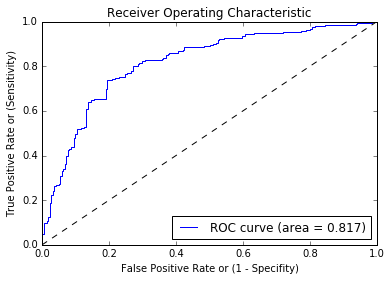

In [18]:
clf = svm.SVC(C=10, gamma=0.01)
clf.fit(X_train, y_train)

evaluate(clf, X_test, y_test)

from sklearn.metrics import roc_curve, auc
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=None)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

Logistic Regression             测试集acc/recall:   0.73786407767/ 0.733979294497 训练集acc/recall:  0.727825030377/ 0.727825030377
Linear SVM                      测试集acc/recall:  0.718446601942/ 0.711615455687 训练集acc/recall:  0.725394896719/ 0.725394896719
RBF SVM                         测试集acc/recall:  0.740291262136/ 0.734464949895 训练集acc/recall:  0.801336573512/ 0.801336573512
Decision Tree                   测试集acc/recall:  0.735436893204/ 0.726031129326 训练集acc/recall:  0.771567436209/ 0.771567436209
Random Forest                   测试集acc/recall:  0.699029126214/ 0.689251616877 训练集acc/recall:  0.769744835966/ 0.769744835966
AdaBoost                        测试集acc/recall:  0.735436893204/ 0.729584705409 训练集acc/recall:  0.768529769137/ 0.768529769137
Gradient Boosting Decision Tree 测试集acc/recall:  0.754854368932/ 0.752659259435 训练集acc/recall:  0.931956257594/ 0.931956257594
XGBoost                         测试集acc/recall:  0.754854368932/  0.75159318661 训练集acc/recall:  0.848116646416/ 0.84811

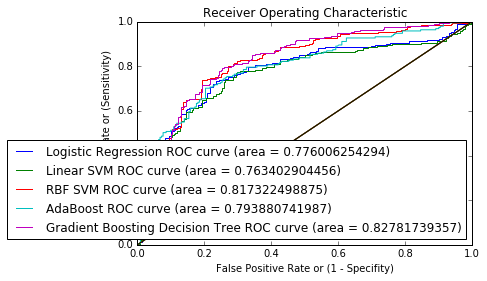

In [19]:
names = ["Logistic Regression", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting Decision Tree", "XGBoost"]
classifiers = [
    LogisticRegression(C=10),
    svm.SVC(kernel="linear", C=0.025),
    svm.SVC(gamma=0.01, C=10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=9),
    XGBClassifier()]
# {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 9}
for name, clf in zip(names,classifiers):
    clf.fit(X_train, y_train)
    print "{:31} 测试集acc/recall: {:15}/{:15} 训练集acc/recall: {:15}/{:15}".format(name, 
        evaluate(clf, X_test, y_test),recall_score(y_test, clf.predict(X_test), average='macro'), 
        evaluate(clf, X_train, y_train), recall_score(y_train, clf.predict(X_train), average='micro'))
    
for name, clf in zip(names, classifiers):
    try: 
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        print '{}特征权值分布为: '.format(name)
        for f in range(X_train.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    except AttributeError:
        print '{} has no feture_importances_'.format(name)
    
# b: blue
# g: green
# r: red
# c: cyan
# m: magenta
# y: yellow
# k: black
# w: white
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for name, clf, color in zip(names,classifiers, colors):
    # y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    try:
        y_score = clf.decision_function(X_test)
    except AttributeError:
        print '{} has no decision_function'.format(name)
        continue

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=None)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='{} ROC curve (area = {})'.format(name, roc_auc))
    plt.plot([0, 1], [0, 1], color)  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [20]:
param_grid = {'learning_rate': [1, 0.5, 0.1, 0.05, 0.02, 0.01],
              'max_depth': [2, 4, 6, 8],
              'min_samples_leaf': [3, 5, 9, 11, 13, 15, 17],
              'n_estimators': [10, 100, 500, 1000, 2000, 3000, 4000],
              # 'max_features': [1.0, 0.3, 0.1] ## not         possible in our example (only 1 fx)
             }

# est = GradientBoostingClassifier({'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 9})
# this may take some minutes
gs_cv = GridSearchCV(GradientBoostingClassifier(), param_grid, n_jobs=4).fit(X_train, y_train)
print gs_cv.best_params_


# best hyperparameter setting

# est.fit(X_train, y_train)
evaluate(gs_cv, X_test, y_test)

{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 9}


0.7548543689320388

In [ ]:
# C_range = np.logspace(-2, 10, 13)
# gamma_range = np.logspace(-9, 3, 13)
# param_grid = dict(gamma=gamma_range, C=C_range)
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
# grid.fit(X_train, y_train)

# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

def visual_gridsearch(model, X, y):
    C_range = np.logspace(-2, 10, 13)
    gamma_range = np.logspace(-9, 3, 13)
    param_grid = dict(gamma=gamma_range, C=C_range)
    
    #cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(model, param_grid=param_grid)
    grid.fit(X_train, y_train)
    scores = [x[1] for x in grid.grid_scores_]
    scores = np.array(scores).reshape(len(C_range), len(gamma_range))
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=ddlheatmap)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title(
        "The best parameters are {} with a score of {:0.2f}.".format(
        grid.best_params_, grid.best_score_)
    )
    plt.show()

visual_gridsearch(svm.SVC(), X_train, y_train)

In [14]:
from sklearn.feature_selection import SelectFromModel
def feature_select(clf, X_train, y_train, X_test):
    # 预训练
    clf.fit(X_train, y_train)
    
    # 评估特征
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("特征权值分布为: ")
    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    # 过滤掉权值小于threshold的特征
    model = SelectFromModel(clf, threshold=0.045, prefit=True)
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)
    print '训练集和测试集的容量以及选择的特征数为: ', X_train_new.shape, X_test_new.shape
    # 返回压缩特征之后的训练集和测试集
    return X_train_new, X_test_new

In [15]:
index = 6
X_train_compressed, X_test_compressed = feature_select(classifiers[index], X_train, y_train, X_test)

for name, clf in zip(names,classifiers):
    clf.fit(X_train_compressed, y_train)
    
    print "{:31} 测试集acc: {:15} 训练集acc: {:15}".format(name, evaluate(clf, X_test_compressed, y_test), evaluate(clf, X_train_compressed, y_train))
    print "{:31} 测试集recall: {:15} 训练集recall: {:15}".format(name, 
        recall_score(y_test, clf.predict(X_test_compressed)), 
        recall_score(y_train, clf.predict(X_train_compressed)))

特征权值分布为: 
1. feature 19 (0.080943)
2. feature 5 (0.067727)
3. feature 4 (0.064949)
4. feature 20 (0.061378)
5. feature 11 (0.053291)
6. feature 25 (0.052155)
7. feature 23 (0.049616)
8. feature 22 (0.048650)
9. feature 7 (0.046396)
10. feature 3 (0.046394)
11. feature 21 (0.043522)
12. feature 6 (0.042964)
13. feature 2 (0.038248)
14. feature 24 (0.036513)
15. feature 9 (0.034192)
16. feature 16 (0.034098)
17. feature 14 (0.032823)
18. feature 12 (0.031427)
19. feature 10 (0.031298)
20. feature 8 (0.022075)
21. feature 18 (0.018258)
22. feature 0 (0.017468)
23. feature 1 (0.015370)
24. feature 13 (0.013127)
25. feature 15 (0.011011)
26. feature 17 (0.006105)
训练集和测试集的容量以及选择的特征数为:  (1646, 10) (412, 10)
Logistic Regression             测试集acc:  0.735436893204 训练集acc:  0.719319562576
Logistic Regression             测试集recall:  0.638743455497 训练集recall:  0.663143989432
Linear SVM                      测试集acc:   0.72572815534 训练集acc:  0.720534629405
Linear SVM                      测试集recall:  

### 年龄预测

In [174]:
from sklearn.linear_model import LinearRegression

In [175]:
def age_preprocess(data):
    df = data.copy()
    # 去掉有缺失维度的数据
    df = df.replace(to_replace='?', value=np.nan)
    df = df.dropna(how='any')
    #pd.get_dummies(data_set)  # one-hot 但是会增加列数, 计算会变慢, 特别是类别很多的时候
    df['age'] = df['age'].apply(lambda x: x / 5).astype(int)
    selected_names = [name for name in df.columns if name != 'id' and name != 'sex' and name != 'age']
    X_data = df[selected_names].as_matrix()
    y_data = df['age'].as_matrix()
    # SVM 一般要对数据做归一化处理
    X_data = preprocessing.scale(X_data)
    return X_data, y_data
    

In [176]:
X_data_age, y_data_age = age_preprocess(data)
# 把刚刚学习到的 sex加入,作为年龄的特征.
# X_data_age = np.column_stack((X_data_age, y_data))

In [177]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_data_age, y_data_age, test_size=0.20, random_state=1)

In [179]:
names = ["Logistic Regression", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting Decision Tree", "XGBoost"]
classifiers = [
    LogisticRegression(C=10),
    svm.SVC(kernel="linear", C=0.025),
    svm.SVC(gamma=0.01, C=10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=9),
    XGBClassifier()]


for name, clf in zip(names,classifiers):
    clf.fit(X_train, y_train)
    #print "{:31} 测试集准确率: {:15} 训练集准确率: {:15}".format(name, accuracy_score(y_test, clf.predict(X_test)),  accuracy_score(y_train, clf.predict(X_train)))
    print "{:31} 测试集acc/recall: {:15}/{:15} 训练集acc/recall: {:15}/{:15}".format(name, 
        evaluate(clf, X_test, y_test),recall_score(y_test, clf.predict(X_test), average='micro'), 
        evaluate(clf, X_train, y_train), recall_score(y_train, clf.predict(X_train), average='micro'))
    

Logistic Regression             测试集acc/recall:  0.148058252427/ 0.148058252427 训练集acc/recall:  0.215066828676/ 0.215066828676
Linear SVM                      测试集acc/recall:  0.172330097087/ 0.172330097087 训练集acc/recall:  0.185905224787/ 0.185905224787
RBF SVM                         测试集acc/recall:  0.155339805825/ 0.155339805825 训练集acc/recall:  0.313487241798/ 0.313487241798
Decision Tree                   测试集acc/recall:  0.133495145631/ 0.133495145631 训练集acc/recall:  0.227825030377/ 0.227825030377
Random Forest                   测试集acc/recall:  0.174757281553/ 0.174757281553 训练集acc/recall:  0.287363304982/ 0.287363304982
AdaBoost                        测试集acc/recall: 0.0970873786408/0.0970873786408 训练集acc/recall:  0.123329283111/ 0.123329283111
Gradient Boosting Decision Tree 测试集acc/recall:  0.184466019417/ 0.184466019417 训练集acc/recall:  0.998177399757/ 0.998177399757
XGBoost                         测试集acc/recall:  0.174757281553/ 0.174757281553 训练集acc/recall:  0.754556500608/ 0.75455

In [64]:
df = data.copy()
df['age'] = df['age'].apply(lambda x: int(x / 5))
df.tail()

linreg = LinearRegression()
linreg.fit(X_train, y_train)
evaluate(clf, X_test, y_test)

0.1407766990291262

In [30]:
count = 0
for x in range(1,10001):
    x_str = str(x)
    if '4' not in x_str and ('8' in x_str or '6' in x_str):
        count += 1
        print x
print count
y = [0,1,2,3,4,2,2,1]
np.bincount(y)

6
8
16
18
26
28
36
38
56
58
60
61
62
63
65
66
67
68
69
76
78
80
81
82
83
85
86
87
88
89
96
98
106
108
116
118
126
128
136
138
156
158
160
161
162
163
165
166
167
168
169
176
178
180
181
182
183
185
186
187
188
189
196
198
206
208
216
218
226
228
236
238
256
258
260
261
262
263
265
266
267
268
269
276
278
280
281
282
283
285
286
287
288
289
296
298
306
308
316
318
326
328
336
338
356
358
360
361
362
363
365
366
367
368
369
376
378
380
381
382
383
385
386
387
388
389
396
398
506
508
516
518
526
528
536
538
556
558
560
561
562
563
565
566
567
568
569
576
578
580
581
582
583
585
586
587
588
589
596
598
600
601
602
603
605
606
607
608
609
610
611
612
613
615
616
617
618
619
620
621
622
623
625
626
627
628
629
630
631
632
633
635
636
637
638
639
650
651
652
653
655
656
657
658
659
660
661
662
663
665
666
667
668
669
670
671
672
673
675
676
677
678
679
680
681
682
683
685
686
687
688
689
690
691
692
693
695
696
697
698
699
706
708
716
718
726
728
736
738
756
758
760
761
762
763
765
766
767
76

array([1, 2, 3, 1, 1])